# Topic analysis of speeches in the Swedish Riksdag 2017-2021

In [2]:
# Standard packages
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sci-kit learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

# NLP packages
import torch
import stanza
# stanza.download('sv') # Download Swedish model, persists once downloaded

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


## Load data and merge to one data set

In [3]:
speeches1718 = pd.read_csv('anforande-201718.csvt', sep=',')
speeches1819 = pd.read_csv('anforande-201819.csvt', sep=',')
speeches1920 = pd.read_csv('anforande-201920.csvt', sep=',')
speeches2021 = pd.read_csv('anforande-202021.csvt', sep=',')

speeches = speeches1718.append([speeches1819, speeches1920, speeches2021], ignore_index=True)
speeches.head()

,dok_id,dok_rm,dok_nummer,dok_datum,avsnittsrubrik,kammaraktivitet,anforande_nummer,talare,parti,anforandetext,intressent_id,rel_dok_id,replik
0,H5091,2017/18,1,2017-09-12 00:00:00,Inledning,NaN,1,TALMANNEN,TALMANNEN,Inledning Jag ber att få hälsa alla hjärtlig...,NaN,NaN,N
1,H50910,2017/18,10,2017-09-26 00:00:00,Svar på interpellation 2016/17:619 om dödsfall...,interpellationsdebatt,1,Socialministern Annika Strandhäll (S),S,Svar på interpellationer Herr talman! Jeff A...,5.304252e+11,H5C120170926ip,N
2,H50910,2017/18,10,2017-09-26 00:00:00,Svar på interpellation 2016/17:621 om brister ...,interpellationsdebatt,10,Socialministern Annika Strandhäll (S),S,Herr talman! Lotta Finstorp har frågat mig vi...,5.304252e+11,H5C120170926ip,N
3,H50910,2017/18,10,2017-09-26 00:00:00,Svar på interpellation 2016/17:621 om brister ...,interpellationsdebatt,11,Lotta Finstorp (M),M,Herr talman! Jag tackar ministern för svaret....,7.505186e+11,H5C120170926ip,N
4,H50910,2017/18,10,2017-09-26 00:00:00,Svar på interpellation 2016/17:621 om brister ...,interpellationsdebatt,12,Socialministern Annika Strandhäll (S),S,Herr talman! Jag tackar Lotta Finstorp för de...,5.304252e+11,H5C120170926ip,N


In [4]:
parties = ['S', 'M', 'MP', 'SD', 'KD', 'V', 'L', 'C', '-']
party_color = ['red', 'mediumblue', 'limegreen', 'gold', 'navy', 'darkred', 'cornflowerblue', 'green', 'black']
color_dict = dict(zip(parties, party_color))

# Select only the political speeches (exclude His Majesty the King,
# the Speaker, and the role of the most senior senator)
speeches = speeches[speeches.parti.isin(parties)]

## Data inspection functions

In [176]:
def plot_speeches_per_party(df_speeches):
    plt.figure(figsize=(7,7))
    plt.bar(parties, df_speeches.parti.value_counts(), color = party_color)
    plt.title('Number of speeches given by party representatives', fontsize=18)
    plt.ylabel('Speeches', fontsize=16)
    plt.show()
    
def plot_speech_lengths(speeches_df):
    speech_lengths = []
    for sp in speeches_df.anforandetext.values:
        speech_lengths.append(len(sp.split(' ')))

    plt.figure(figsize=(7,7))
    plt.hist(speech_lengths, bins=200)
    plt.xlabel('Number of words (tokens)', fontsize=16)
    plt.ylabel('Speeches', fontsize=16)
    plt.show()

def get_month(time_str):
    # Takes a string 'yyyy-mm-dd xx:xx:xx' and returns 'yyyy-mm'
    time = time_str.split('-')
    month = '-'.join(time[0:2])
    return month

def plot_speech_dates(speeches_df):
    dates = list(map(get_month, speeches_df.dok_datum.to_list()))
    unique, counts = np.unique(dates, return_counts=True)

    plt.figure(figsize=(8,8))
    plt.barh(unique, counts, color='orange')
    plt.title('Number of speeches given in each month', fontsize=18)
    plt.show()
    

# Data inspection

### Number of speeches per party and per period

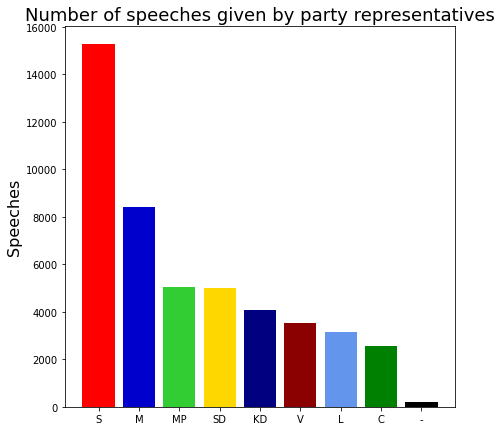

In [177]:
plot_speeches_per_party(speeches)

### Distribution over time

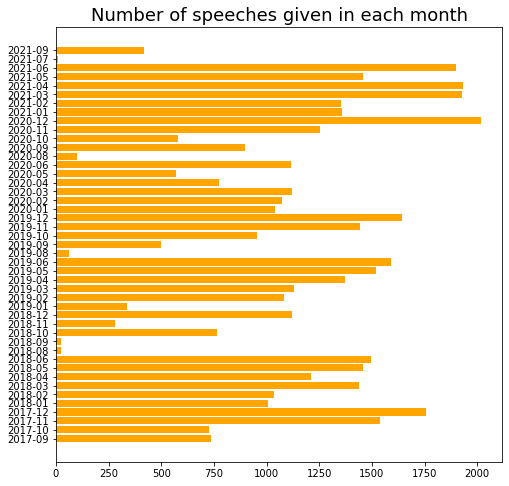

In [178]:
plot_speech_dates(speeches)

### Distribution of speech lengths

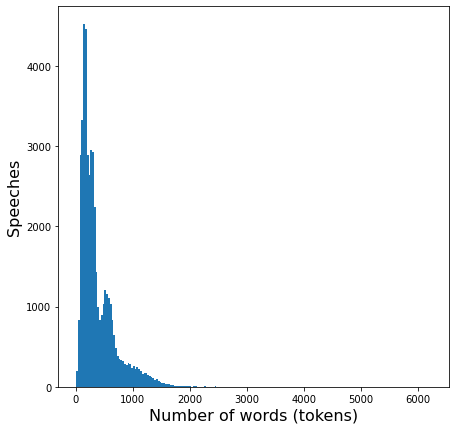

In [179]:
plot_speech_lengths(speeches)

### Types of activities and subjects

In [8]:
speeches.kammaraktivitet.value_counts(dropna=False)

ärendedebatt                  16336
interpellationsdebatt         13412
NaN                            8765
frågestund                     6804
statsministerns frågestund      930
aktuell debatt                  897
Name: kammaraktivitet, dtype: int64

In [9]:
subjects = speeches.avsnittsrubrik.value_counts().index
cts = speeches.avsnittsrubrik.value_counts().values
for i in range(len(cts)):
    print(subjects[i], cts[i])

Frågestund 6804
Partiledardebatt 1420
Statsministerns frågestund 878
Utrikespolitisk debatt 707
Återrapportering från Europeiska rådets möte 447
Allmänpolitisk debatt (forts. från prot. 7) 399
Debatt med anledning av vårpropositionens avlämnande 284
Debatt med anledning av budgetpropositionens avlämnande 277
Samhällsplanering, bostadsförsörjning och byggande samt konsumentpolitik 232
Utbildning och universitetsforskning 227
Kommunikationer 222
Näringsliv 188
Rättsväsendet 178
Hälsovård, sjukvård och social omsorg 176
Partiledardebatt med anledning av val till Europaparlamentet 168
Allmän miljö- och naturvård 163
Kultur, medier, trossamfund och fritid 162
Jämställdhet och nyanlända invandrares etablering 152
Allmänpolitisk debatt (forts. från prot. 8) 151
Energi 142
Studiestöd 141
Ekonomisk trygghet vid sjukdom och funktionsnedsättning 134
Arbetsmarknad och arbetsliv och Arbetsmarknadspolitik och arbetslöshetsförsäkringen 133
EU-politisk debatt 128
Statens budget 2021 - rambeslutet 125


Svar på interpellationerna 2017/18:331, 333 och 352 om Turkiets hot mot Afrin och kurderna i Rojavaprovinsen i Syrien 15
Forskning 15
Svar på interpellation 2016/17:625 om vinstbegränsning i skolan 15
Strategisk exportkontroll 2019 - krigsmateriel och produkter med dubbla användningsområden 15
Riksrevisionens rapport om konsumentskydd vid köp av nyproducerade bostadsrätter 15
Civila samhället inklusive trossamfund 15
Skattereduktion för boende i vissa glest befolkade områden - regional skattereduktion 15
Svar på interpellationerna 2020/21:643, 644 och 667 om antalet vargar på landsbygden 15
Kommissionens EU-strategi för automatiserad och uppkopplad rörlighet  15
Vistelsekommuners ansvar för socialtjänstinsatser  15
Genomförande av 2017 års ändringsdirektiv till EU:s vapendirektiv 15
Integritetsskydd vid signalspaning i försvarsunderrättelseverksamhet  15
(forts. från § 8) Cykelfrågor (forts. TU3) 15
Åtgärder avseende stöd vid korttidsarbete 15
Beskattning av företag, kapital och fastig

Svar på interpellation 2018/19:18 om kärnkraft för framtida elbehov 9
Svar på interpellation 2020/21:37 om striderna i Nagorno-Karabach 9
Svar på interpellation 2018/19:1 om försvarsgarantier mellan Sverige och USA 9
Svar på interpellation 2018/19:47 om åtgärder mot frånvaro 9
Svar på interpellation 2020/21:786 om utredningen om Bromma flygplats 9
Svar på interpellation 2020/21:804 om svenskt kustfiske 9
Svar på interpellation 2020/21:803 om upphörandet av det allmänna uppdraget 9
Svar på interpellation 2020/21:730 om Israels ockupation av Palestina 9
Svar på interpellation 2020/21:763 om åtgärder för att skydda barn från hederskultur 9
Svar på interpellation 2020/21:740 om långtidsarbetslösheten 9
Internationella adoptioner 9
Svar på interpellation 2020/21:2 om åtgärder mot ungdomsrån 9
Svar på interpellation 2020/21:14 om framtiden för inrikesflyget och Bromma flygplats 9
Svar på interpellation 2018/19:79 om dödsfall på jobbet 9
Svar på interpellation 2018/19:49 om avgiftsfria nation

Svar på interpellation 2017/18:378 om odemokratiska påverkansmetoder 9
Svar på interpellation 2017/18:373 om studieförbundet Ibn Rushd 9
Svar på interpellation 2017/18:199 om placeringen av EU:s läkemedelsmyndighet 9
Svar på interpellation 2020/21:482 om åtgärder mot närgångna vargar 9
Svar på interpellation 2017/18:390 om kollektivavtal vid upphandling 9
Svar på interpellation 2017/18:562 om unga vuxna med psykisk ohälsa 9
Svar på interpellation 2017/18:224 om ett fungerande växtskydd för jordbruket 9
Svar på interpellation 2017/18:9 om Systembolagets lobbying i politiska sakfrågor 9
Svar på interpellation 2017/18:237 om skogsbruket, äganderätten och framtiden 9
Svar på interpellation 2017/18:321 om bilstödet 9
Svar på interpellation 2017/18:463 om Luftfartsverkets verksamhet i Förenade Arabemiraten 9
Svar på interpellation 2017/18:457 om försäljning av vildsvinskött 9
Svar på interpellation 2017/18:458 om EU:s antibiotikastrategi 9
Svar på interpellation 2020/21:475 om slutförvaret i

Svar på interpellation 2020/21:277 om ett statligt startlån för förstagångsköpare 7
Svar på interpellation 2020/21:663 om svenskars dödsfall i Dominikanska republiken 7
Svar på interpellation 2020/21:658 om folkmord på den uiguriska folkgruppen i Xinjiang 7
Svar på interpellation 2020/21:651 om Turkiets utträde ur Europarådets konvention mot våld mot kvinnor 7
Svar på interpellation 2020/21:636 om observatörskap i FN:s konvention mot kärnvapen 7
Svar på interpellation 2020/21:326 om uppehållstillstånd av humanitära skäl 7
Svar på interpellation 2020/21:334 om stöldligornas framfart i Sverige 7
Svar på interpellation 2020/21:252 om skjutfält för hemvärnets behov i Kalmar län 7
Svar på interpellation 2017/18:450 om regelförbättringar 7
Svar på interpellation 2017/18:35 om långa kötider till körprov 7
Svar på interpellation 2017/18:52 om Trafikverkets projekt Rätt väghållaransvar 7
Svar på interpellation 2020/21:649 om utsläppsgränser i EU:s taxonomi 7
Svar på interpellation 2020/21:457 o

Svar på interpellation 2020/21:177 om barn och ungdomar som slutar idrotta 7
Svar på interpellation 2020/21:181 om bättre tillgång till läkemedelsassisterad behandling vid opioidberoende 7
Svar på interpellation 2020/21:180 om överförskrivning och missbruk av narkotikaklassade läkemedel 7
Svar på interpellation 2020/21:165 om den tillfälliga lagen om utökat mandat för regeringen under pandemin 7
Svar på interpellation 2020/21:170 om kapacitetsbrist i Skåne och övriga Sverige 7
Svar på interpellation 2020/21:147 om en flexibel föräldraförsäkring 7
Svar på interpellation 2017/18:525 om Haparandabanan 7
Svar på interpellation 2020/21:525 om skydd av personuppgifter för personal inom de rättsvårdande myndigheterna 7
Förlängning av lagen om tillfälliga smittskyddsåtgärder på serveringsställen 7
Svar på interpellation 2017/18:521 om flexjobb 7
Svar på interpellation 2017/18:478 om kulturmomsen 7
Svar på interpellation 2020/21:160 om det framtida reseavdraget 7
Svar på interpellation 2017/18:

Svar på interpellation 2020/21:879 om krispolitikens fördelningspolitiska effekter 7
Svar på interpellation 2020/21:17 om konsumenters reklamationsrätt 7
Svar på interpellation 2020/21:493 om kortare straff för brottslingar som förlorar jobbet 7
Svar på interpellation 2020/21:489 om europeiska miniminivåer 7
Svar på interpellation 2020/21:38 om kostnader och tidsram för införandet av ERTMS i Sverige 7
Svar på interpellation 2020/21:32 om en avveckling av Bromma flygplats 7
Svar på interpellation 2020/21:31 om underhållet av Stångådalsbanan, Tjustbanan och övriga regionala järnvägar 7
Svar på interpellation 2020/21:24 om polisbristen på landsbygden 7
Svar på interpellation 2020/21:8 om åtgärder kopplade till gängkriminalitet 7
Svar på interpellation 2020/21:7 om straffrättsliga åtgärder mot brister vid transport av farligt gods 7
Svar på interpellation 2020/21:124 om aborträtten i Polen 7
Svar på interpellation 2020/21:456 om EU-direktiv om minimilöner 7
Svar på interpellation 2020/21:4

Svar på interpellation 2017/18:345 om snöröjning i Norrland 7
Svar på interpellation 2017/18:282 om Lantmäteriets handläggningstider 7
Svar på interpellation 2017/18:348 om Migrationsverkets benämning av kristna församlingar 7
Svar på interpellation 2017/18:292 om uppföljning av kollektivtrafiklagen 7
Svar på interpellation 2020/21:400 om adoptioner från Chile 7
Svar på interpellationerna 2017/18:339, 340 och 342 om svarta körskolor 7
Svar på interpellation 2020/21:505 om sänkta banavgifter för järnvägen 7
Svar på interpellation 2020/21:407 om statsbidraget till etniska organisationer 7
Svar på interpellation 2020/21:379 om länsstyrelsernas hantering av bygglovsprocesser 7
Svar på interpellation 2017/18:276 om Nya Ostkustbanan 7
Svar på interpellation 2018/19:231 om framtiden för svenskt sportskytte 7
Svar på interpellation 2018/19:256 om strategin för romsk inkludering 7
Svar på interpellation 2018/19:255 om slöjförbud i den svenska för- och grundskolan 7
Svar på interpellation 2018/1

Svar på interpellation 2019/20:145 om ungdomsbrottslighet och straffrabatt 7
Svar på interpellation 2019/20:146 om tjänstemannastatus för all blåljuspersonal 7
Svar på interpellation 2016/17:597 om trygghet i vården 7
Svar på interpellation 2016/17:595 om arvoden i bolagsstyrelser 7
Svar på interpellation 2016/17:599 om överbeläggning inom akutsjukvården 7
Svar på interpellation 2018/19:316 om Kostnadsutjämningsutredningen 7
Svar på interpellation 2018/19:311 om ändamålsenligt materiel för kvinnor i försvaret 7
Svar på interpellation 2016/17:601 om väntetider inom barn- och ungdomspsykiatrin 7
Svar på interpellation 2016/17:614 om upprätthållande av abortlagstiftningens intention 7
Svar på interpellation 2016/17:605 om skärpt kontroll vid egen ansökan om konkurs 7
Svar på interpellation 2019/20:135 om sjukvårdens ekonomi 7
Svar på interpellation 2019/20:128 om nedskärningar i sjukvården 7
Svar på interpellation 2019/20:124 om särskilda köer till svensk sjukvård 7
Svar på interpellation

Svar på interpellation 2017/18:212 om skrotbilar 7
Svar på interpellation 2019/20:39 om arbetslöshetsmålet 7
Svar på interpellation 2019/20:59 om elbristen i Skåne 7
Svar på interpellation 2019/20:407 om prioritering av elever vid skolval 7
Svar på interpellation 2019/20:79 om elsäkerhet 7
Svar på interpellation 2019/20:67 om nationens ansvar för läkemedelsförsörjningen 7
Svar på interpellation 2019/20:64 om åtgärder mot den ökande psykiska ohälsan 7
Svar på interpellation 2017/18:161 om kriminalisering av köp av hyreskontrakt 7
Svar på interpellation 2020/21:323 om åtgärder i förhållande till Iran 7
Svar på interpellation 2019/20:52 om beställaransvar utan verkan 7
Svar på interpellation 2017/18:315 om bostäder för seniorer 7
Svar på interpellation 2019/20:60 om infrastruktur i hela landet 7
Svar på interpellation 2019/20:68 om medicinska krav för tyngre behörigheter 7
Svar på interpellation 2019/20:71 om Kinas efterlevnad av WTO:s regelverk 7
Svar på interpellation 2019/20:72 om sned

(forts. från § 12) Beskattning av elektroniska cigaretter och vissa andra nikotinhaltiga produkter (forts. SkU17) 4
Ytterligare förstärkt nedsättning av arbetsgivaravgifter för personer som arbetar med forskning eller utveckling 4
Svar på interpellation 2017/18:58 om överklagande vid offentlig upphandling 4
Svar på interpellation 2020/21:469 om sjukförsäkringen, samverkansproblem och SGI 4
(forts. från § 6) Högskolan (forts. UbU15) 4
(forts.) Svar på interpellation 2019/20:131 om kreditrestriktioners inverkan på bostadsmarknaden 4
Undersökningstillstånd 4
Polisens kameraövervakning 4
Styrning av kulturområdets institutioner 4
Trängselskatt i Marieholmstunneln i Göteborg 4
Riksrevisionens rapport om flerbarnstillägget i barnbidraget 4
(forts. från § 6) Socialförsäkringsfrågor (forts. SfU21) 4
(forts. från § 6) Landsbygdspolitik (forts. MJU8) 4
Statlig förvaltning och statistikfrågor 4
(forts.) Svar på interpellation 2017/18:91 om försämrade livsvillkor för grisar 4
(forts. från § 9) Sva

### Subject-specific debates

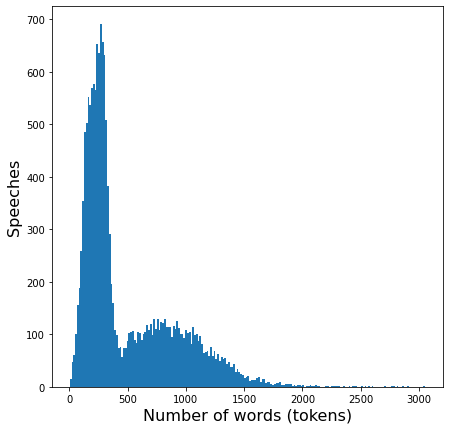

In [180]:
arendedebatt = speeches[speeches.kammaraktivitet == 'ärendedebatt']
plot_speech_lengths(arendedebatt)

In [53]:
subjects_ad = arendedebatt.avsnittsrubrik.value_counts().index
cts_ad = arendedebatt.avsnittsrubrik.value_counts().values
for i in range(len(cts_ad)):
    print(subjects_ad[i], cts_ad[i])

Svar på interpellationerna 2018/19:272 och 275 om skattebelastningen på privatbilismen 21
Svar på interpellationerna 2017/18:196, 197, 198, 204 och 220 om följderna av hamnkonflikten i Göteborg och rätten att vidta stridsåtgärder på arbetsmarknaden  20
Svar på interpellationerna 2019/20:252 och 253 om en avgift för att lägga upp virke längs vägar 18
Svar på interpellationerna 2020/21:298 och 320 om stöd till restaurangnäringen 18
Svar på interpellationerna 2018/19:244, 246, 247, 248, 249 och 251 om påtryckningar mot Försäkringskassan 18
Svar på interpellation 2017/18:271 om vinstförbud i vården 17
Svar på interpellationerna 2020/21:312, 315, 316 och 317 om arbetslösheten i Sverige i förhållande till övriga EU 16
Svar på interpellationerna 2017/18:367 och 374 om Mora-Siljan flygplats 16
Svar på interpellation 2016/17:625 om vinstbegränsning i skolan 15
Svar på interpellationerna 2020/21:643, 644 och 667 om antalet vargar på landsbygden 15
Svar på interpellationerna 2017/18:331, 333 och 

Svar på interpellation 2020/21:186 om skatteförslagens sysselsättningseffekter 7
Svar på interpellation 2020/21:177 om barn och ungdomar som slutar idrotta 7
Svar på interpellation 2020/21:181 om bättre tillgång till läkemedelsassisterad behandling vid opioidberoende 7
Svar på interpellation 2019/20:418 om regeringens beslut ur ett regionalt rättviseperspektiv 7
Svar på interpellation 2019/20:457 om säkerhetsbrister vid ungdomshem 7
Svar på interpellation 2019/20:463 om ersättning för att hindra smittspridning i riskgrupper 7
Svar på interpellation 2020/21:90 om det kommunala vetot 7
Svar på interpellation 2020/21:173 om föräldrapåverkan på skolans personal 7
Svar på interpellation 2020/21:149 om privatekonomi i skolans undervisning 7
Svar på interpellation 2020/21:199 om elproduktion i norra Sverige 7
Svar på interpellation 2020/21:172 om ytterligare dispens för yrkesförarkompetens 7
Svar på interpellation 2020/21:192 om hot mot förtroendevalda 7
Svar på interpellation 2020/21:184 om 

Svar på interpellation 2019/20:243 om nedläggning av den nationella hjälplinjen 7
Svar på interpellation 2019/20:192 om olagliga adoptioner från Chile 7
Svar på interpellation 2019/20:218 om insatser mot hedersvåldet 7
Svar på interpellation 2019/20:244 om fler reformer för att öka andelen ägt boende 7
Svar på interpellation 2019/20:198 om det fria skolvalet 7
Svar på interpellation 2019/20:200 om definitionen av magasin 7
Svar på interpellation 2019/20:107 om slopande av överskottsmålet 7
Svar på interpellation 2019/20:140 om bristfälligt vinterunderhåll på våra vägar 7
Svar på interpellation 2019/20:125 om habiliteringsersättning i alla kommuner 7
Svar på interpellation 2019/20:88 om en huvudman för personer med samsjuklighet, beroendesjukdom och psykisk ohälsa 7
Svar på interpellation 2019/20:136 om en nationell handlingsplan mot bortförande och bortgifte av barn 7
Svar på interpellation 2019/20:150 om medinflytande för totalförsvarspliktiga 7
Svar på interpellation 2019/20:137 om M

## Select subsample to use in analysis
Using a specific year to process every speech in the set - the speeches from 2018/2019 are suitable.

In [165]:
selected_speeches = speeches1819
selected_speeches.shape

(9387, 13)

# Vectorize speeches
We begin by loading the processing pipeline. We find the names of the speakers so that they can be removed from the speeches later. We also import stop words for politics from https://github.com/peterdalle/svensktext/tree/master/stoppord by Dahlgren, P. M., extended by me with words included in the data set speeches, such as 'talman', 'herr', 'fru', 'mergeformat', 'kantrubrik' etc (the latter are formatting commands that for some reason are included in the speeches).

The standard pipeline has some issues with certain words, create a custom one instead

In [12]:
# Initialize Swedish neural pipeline
# nlp = stanza.Pipeline('sv') # Standard options
# nlp = stanza.Pipeline('sv', processors='tokenize,pos,lemma', use_gpu=True, pos_batch_size=3000)

user_name = ''

# Create custom pipeline
model = torch.load(f'C:/Users/{user_name}/stanza_resources/sv/lemma/talbanken.pt', map_location='cpu')
word_dict, composite_dict = model['dicts']

def add_word(word, lemma, w_class):
    composite_dict[(word, w_class)] = lemma
    word_dict[word] = lemma

# Add words that are correctly handled in the pretrained pipeline.
# 'skola' especially causes trouble
add_word('skola', 'skola', 'NOUN')
add_word('ska', 'ska', 'AUX')
add_word('ska', 'ska', 'VERB')
add_word('yrka', 'yrka', 'VERB')
add_word('yrkar', 'yrka', 'VERB')
add_word('vikten', 'vikt', 'NOUN')

torch.save(model, f'C:/Users/{user_name}/stanza_resources/sv/lemma/talbanken_customized.pt')

nlp_custom = stanza.Pipeline('sv', processors='tokenize,pos,lemma', lemma_model_path=f'C:/Users/{user_name}/stanza_resources/sv/lemma/talbanken_customized.pt')

2021-12-14 21:22:58 INFO: Loading these models for language: sv (Swedish):
| Processor | Package                 |
---------------------------------------
| tokenize  | talbanken               |
| pos       | talbanken               |
| lemma     | C:/Users/j...tomized.pt |

2021-12-14 21:22:58 INFO: Use device: cpu
2021-12-14 21:22:58 INFO: Loading: tokenize
2021-12-14 21:22:58 INFO: Loading: pos
2021-12-14 21:22:58 INFO: Loading: lemma
2021-12-14 21:22:59 INFO: Done loading processors!


## Preprocessing

In [182]:
# Custom preprocessor using stanza documents
def custom_preprocess(df, n_samples, random=False):
    """
    Function that takes a data frame and returns
    a list of strings (one for each document) that
    are lemmatized.
    
    Input:
        - df: A data frame of speeches
        - n_samples: the number of documents to extract
        - random: boolean indicating random sampling (optional)
    
    Returns:
        - A list of strings with lemmatized documents.
    
    """
    text = df.anforandetext
    if n_samples > len(text):
        n_samples = len(text)
        print(f'Number of samples was larger than data frame. Using maximum number of entries ({len(text)}).')
        
    # Wrap each document with a stanza.Document object
    if random:
        in_docs = [stanza.Document([], text=d) for d in text.sample(n_samples).values]
    else:
        in_docs = [stanza.Document([], text=d) for d in text.values[0:n_samples]]

    t = time.time()
    out_docs = nlp_custom(in_docs)

    tokens = []
    for doc in out_docs:
        tokens_ = []
        for sentence in doc.sentences:
            tokens_.extend([word.lemma for word in sentence.words])
        tokens.append(' '.join(tokens_))

    t = time.time() - t
    print(f'Time taken for {n_samples} speeches:', str(t)[0:6], 'seconds')
    
    return tokens

# Preprocessor that may be passed to the vectorizer
def preprocess(text):
    doc = nlp_custom(text)
    tokens = []
    for sentence in doc.sentences:
        tokens.extend([word.lemma for word in sentence.words])
    return tokens

In [315]:
# Find names
names = ' '.join(list(selected_speeches.talare.unique())).split(' ')
name_df = pd.DataFrame(names, columns=['names'])
name_df = name_df.drop_duplicates().sort_values(by='names')
name_df.head()
names = list(name_df.names)

# Remove titles and party tags, and transform to lower case
names_lc = [name.lower() for name in names if 'minister' not in name and 'Statsrådet' not in name and '(' not in name]
# print(names_lc)

# Import stopwords
stoppord = pd.read_csv('stoppord-politik-komp16-2021-12-08.csv', encoding='utf-16')
stop_words_ = list(stoppord.word)

stop_words_.extend(names_lc)

# print(stop_words_)

# Preprocess and remove duplicates
sw = set([preprocess(word)[0] for word in stop_words_])
#sw = set(preprocess(' '.join(stop_words_)))
print(len(sw))
print(sw)

887
{'kristina', 'jag', 'kunna', 'måste', 'aylin', 'magdal', 'westlund', 'johnny', 'anefur', 'för', 'annica', 'karap', 'matilda', 'ny', 'marie', 'larsen', 'verkligen', 'heie', 'ellen', 'petersson', 'fyra', 'brunegård', 'åttio', 'vilhelmsson', 'pettersson', 'axén', 'quicklund', 'lennström', 'sandell', 'möjligtvis', 'vänster', 'robert', 'mången', 'hit', 'både', 'sju', 'haddad', 'hillevi', 'sätherberg', 'kanske', 'bouveng', 'ann-christin', 'bohlin', 'g', 'begic', 'heta', 'jamal', 'coenradda', 'ekström', 'lindhagen', 'varifrån', 'roza', 'svantorp', 'saila', 'cederfelt', 'säga', 'ibland', 'mot', 'christina', 'loord', 'wärnick', 'angelica', 'lodenius', 'brodin', 'tomas', 'serkan', 'enligt', 'inför', 'varas', 'malm', 'helene', 'beatrice', 'tills', 'helmersson', 'komma', 'eva', 'siste', 'jen', 'kadir', 'alltså', 'segerlind', 'selin', 'snart', 'alexand', 'christian', 'markus', 'seppälä', 'ericson', 'olikt', 'szatmari', 'sexton', 'så', 'boriana', 'enholm', 'nyberg', 'linus', 'köse', 'tsouplaki',

In [12]:
# Sort and save updated stop word list
#stoppord_ = pd.DataFrame(list(sw), columns=['word'])
#stoppord_ = stoppord_.sort_values(by='word').drop_duplicates()
#stoppord_.to_csv('stoppord-politik-v2-utf16-2021-12-08.csv', index=False, encoding='utf-16')

### Tokenize documents
Save the tokenized document to avoid doing the costly preprocessing again

In [183]:
n_docs = 10000
tokens = custom_preprocess(selected_speeches, n_docs, random=False)

Number of samples was larger than data frame. Using maximum number of entries (9387).
Time taken for 9387 speeches: 6425.4 seconds


In [184]:
df_tokens = pd.DataFrame(tokens, columns=['tokens'])
df_tokens.to_csv('lemmatized_speeches1819-utf16.csv', index=False, encoding='utf-16')

__Not using the POS tagger speeds up the processing, but the result is worse - the words are not properly lemmatized.__

Time taken for 5000 speeches: 2650.6 seconds; Time taken for 10000 speeches: 4967.3 seconds

Verify that the prpreocessed text looks reasonable:

In [187]:
print(selected_speeches.anforandetext[20])

 Återrapportering från Europeiska rådets möte  Herr talman! I förra veckan sammanträdde Europeiska rådet i Bryssel. Diskussionen på onsdagskvällen ägnades åt förhandlingarna med Storbritannien om utträdet ur EU. På torsdagen gick vi igenom läget i förhandlingarna i frågor om migration  EU:s inre säkerhet och utrikesrelationer. På torsdagen hölls också ett informellt eurotoppmöte  dit även länder som inte har euron som valuta hade bjudits in. Som bekant kunde jag inte delta på detta möte beroende på de inrikespolitiska förhållandena här hemma.  Herr talman! Vi började alltså med brexit. Premiärminister May hade bjudits in att redogöra för sin syn på förhandlingarna. Hon signalerade både optimism och en vilja att lösa Irlandsfrågan. Samtidigt stod det dock klart att Storbritanniens förväntningar på hur Irlandsfrågan ska lösas fortfarande står långt från vad EU kan erbjuda.  Mays regering motsätter sig fortfarande EU:s förslag att låta Nordirland fortsätta tillämpa EU:s tullregelverk för 

In [188]:
print(tokens[20])

återrapportering från Europeiska råd möte Herr talman ! i förra vecka sammanträdda Europeiska råd i Bryssel . diskussion på onsdagskväll ägna åt förhandling med Storbritannien om utträde ur EU . på torsdag gå vi igenom läge i förhandling i fråga om migration EU inre säkerhet och utrikesrelation . på torsdag höla också en informell eurotoppmöte dit även land som inte ha euron som valuta ha bjuda in . som bekant kunna jag inte delta på denna möte beroende på en inrikespolitisk förhållande här hemma . Herr talman ! vi börja alltså med brexit . premiärminister may ha bjuda in att redogöra för sig syn på förhandling . hon signalera både optimism och en vilja att lösa irlandsfråga . samtidig stå den dock klar att Storbritanniens förväntning på hur irlandsfråga ska lösa fortfarande stå långt från vad EU kunna erbjuda . Mays regering motsätta sig fortfarande EU förslag att låta Nordirland fortsätta tillämpa EU tullregelverk för vara och jordbruksprodukt . britt vilja inte se någon form av kont

## Fit vectorizer object and create indices

In [189]:
# Needs no processor if tokenized from the beginning
vectorizer = TfidfVectorizer(stop_words=sw) # tokenizer=preprocess)
speech_vec = vectorizer.fit_transform(tokens)

# vectorizer = TfidfVectorizer(stop_words=sw, tokenizer=preprocess)
# speech_vec = vectorizer.fit_transform(speeches.anforandetext.sample(500))

c:\users\joel_\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['annelie', 'annica', 'arne', 'britt', 'care', 'carl', 'christin', 'christine', 'el', 'elmi', 'haj', 'justitie', 'kultur', 'miljö', 'olof', 'oskar', 'paarup', 'peters', 'sofie', 'sven'] not in stop_words.
  warnings.warn(


In [190]:
vocab = vectorizer.vocabulary_
inv_vocab = {val:key for key, val in vocab.items()}

print(speech_vec.shape)

(9387, 46659)


### Common/uncommon words (idf)

Print the 300 most common words, and the 200 least common words

In [191]:
ix = np.argsort(vectorizer.idf_)
common_words = []
for i in ix[:350]:
    common_words.append( inv_vocab[i] )
print(common_words)

print('')
uncommon_words = []
for i in ix[-200:]:
    uncommon_words.append( inv_vocab[i] )
print(uncommon_words)

['sverige', 'regering', 'land', 'tycka', 'svensk', 'handla', 'många', 'tid', 'möjlighet', 'väldig', 'människa', 'öka', 'förslag', 'exempel', 'arbete', 'just', 'fortsätta', 'ställa', 'riksdag', 'politik', 'tydlig', 'debatt', 'problem', 'faktisk', 'sak', 'område', 'bygga', 'parti', 'samhälle', 'innebära', 'grund', 'eu', 'moderat', 'tala', 'tänka', 'använda', 'hålla', 'ställe', 'skapa', 'ansvar', 'egen', 'arbeta', 'visa', 'ske', 'minska', 'välja', 'utveckling', 'åtgärd', 'låta', 'samtidig', 'leda', 'börja', 'höra', 'precis', 'stöd', 'kräva', 'antal', 'person', 'pengar', 'yrka', 'svår', 'förutsättning', 'stärka', 'bifall', 'socialdemokrat', 'politisk', 'barn', 'väg', 'anse', 'behov', 'kommun', 'myndighet', 'budget', 'följa', 'genomföra', 'ekonomisk', 'stark', 'jobba', 'naturligtvis', 'gemensam', 'situation', 'värld', 'leva', 'riktig', 'sverigedemokrat', 'införa', 'plats', 'reservation', 'nämligen', 'känna', 'verksamhet', 'ganska', 'driva', 'dessutom', 'nämna', 'konstatera', 'kalla', 'ytter

Look at the distribution of common words

46659


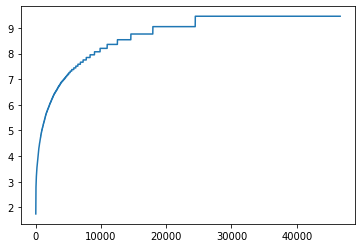

In [192]:
idfs = np.sort(vectorizer.idf_)
print(len(idfs))
plt.plot(idfs)
plt.show()

In [206]:
high_idf_words = []
for i in ix[-41000:]:
    high_idf_words.append( inv_vocab[i] )

In [227]:
high_idf_words_ex = []
for i in ix[-44000:]:
    high_idf_words_ex.append( inv_vocab[i] )

## Adding more stop words

In [316]:
stop_words_.extend(common_words)
# sw_no_commons = set(preprocess(' '.join(stop_words_)))
sw_no_commons = set(stop_words_)
print(len(sw_no_commons))

1386


In [317]:
stop_words_.extend(high_idf_words_ex)
sw_large = set(stop_words_)
#sw_large = set([preprocess(word)[0] for word in stop_words_])
print(len(sw_large))

45330


In [319]:
print('en' in sw_large)
print('skola' in sw_large)

True
False


In [320]:
used_stop_word_set = sw_no_commons

vectorizer = TfidfVectorizer(stop_words=used_stop_word_set)
speech_vec = vectorizer.fit_transform(tokens)

vocab = vectorizer.vocabulary_
inv_vocab = {val:key for key, val in vocab.items()}

print(speech_vec.shape)

c:\users\joel_\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arne', 'britt', 'caren', 'carl', 'christin', 'christine', 'el', 'elmi', 'haj', 'justitie', 'kultur', 'olof', 'oskar', 'paarup', 'petersen', 'sofie', 'sven'] not in stop_words.
  warnings.warn(


## Clustering
Try different numbers of clusters and inspect the cluster topics.

In [194]:
def fit_kmeans(n_clusters, speech_vectors, n_init_=10, random_state_=100):
    """
    Fits and returns a k-means model for the set number of clusters
    
    Input:
        - n_clusters: number of clusters in the k-means model
        - n_init_: number of restarts when training (optional)
        - random_state_: seed of the k-means training process
    
    Returns:
        - km: the fitted k-means model
        - topic: mapping of index to topic (default index 'topics')
    """
    
    km = KMeans(n_clusters, n_init=n_init_, random_state=random_state_)
    km.fit(speech_vectors)
    
    # Default topic dictionary containing only cluster indices
    topic_dict = dict(zip(n_clusters, n_clusters))
    
    return km, topic_dict


def get_cluster_topics(cluster_centers, inv_vocab, n=10, print_=True):
    """
    Returns a list of lists containing the most relevant
    words for each type of speech in each cluster
    
    Parameters:
        - cluster_centers: a list containing the cluster cent
        - n: integer specifying how many words should be returned
    
    Returns:
        - A list of lists containing the n highest
          weighted terms in each cluster
    """
    topics = []
    for c in cluster_centers:
        ix_sort = np.argsort(-c)
        topic = []
        for i in ix_sort[:n]:
            topic.append(inv_vocab[i])
        topics.append(topic)
        if print_:
            print(topic)
            
    return topics


def plot_topic_distribution(predictions, topic_dict, party=None, title_=' '):
    """
    Plot the topic distributions by a histogram where each
    bin contains the number of speeches in each cluster.
    
    Input:
        - predictions: the vector containing the topic predictionss
        - topi_dict: dictionary containing a mapping from a cluster index
                     to a decsription of the topic
        - party: the party name of the speeches that are plotted (optional)
        - title_: title of the produced figure (optional)
        
    No return value.    
    """
    
    n_clusters_ = len(topic_dict)
    
    col = 'gray'
    if party:
        col = color_dict[party]
        if title_ == ' ':
            title_ = f'Topic distribution of speeches by {party} politicians'        
    
    plt.figure(figsize=(7,7))
    n, bins, patches = plt.hist(predictions, bins=[i-0.5 for i in range(n_clusters_+1)], color=col, edgecolor='black')
    xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
    xticks_labels = [ f"{topic_dict[idx]}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
    plt.xticks(xticks, labels = xticks_labels, rotation='vertical')
    
    print("Cluster with most data points:", np.argmax(n))
    
    plt.title(title_)
    plt.show()

### Grid search to find optimal parameters

In [ ]:
n_cl = [1+2*i for i in range(4,70)]
param_grid_ = {'n_clusters': n_cl}
kmeansCV = GridSearchCV(estimator=KMeans(random_state=200), param_grid=param_grid_,
                        scoring=None, n_jobs=-1, refit=True, cv=None)
kmeansCV.fit(speech_vec, None)

best_n_clusters = kmeansCV.best_params_['n_clusters']
print(best_n_clusters)
print(n_cl)

topicsCV = get_cluster_topics(kmeansCV.best_estimator_.cluster_centers_, n=100, print_=False)

In [ ]:
print(topicsCV[23])

It seems that having many clusters gives a better result, perhaps to the point that the model just recreates the labels of the data. The fact that the feature space has many dimensions (one for each word) might reward a model with many clusters.

The topics definitely become more specific using a higher number of clusters. With e.g. 2000 speeches, using about 100 clusters only allow for on average 20 documents in each cluster.

In [321]:
nc = 39
kmeans39 = KMeans(n_clusters = nc, n_init=10, random_state=100)
kmeans39.fit(speech_vec)
topic_dict = dict(zip(range(nc), range(nc)))

In [325]:
topics = get_cluster_topics(kmeans39.cluster_centers_, inv_vocab, n=20, print_=True)

['kulturskola', 'fritidspeng', 'kultur', 'bidrag', 'fritid', 'mus', 'entré', 'kommunal', 'trossamfund', 'familj', 'vilja', 'skola', 'medie', 'försörjningsstöd', 'tillföra', 'generell', 'se', 'återinföra', '100', 'avgift']
['europeiska', 'union', 'möte', 'återrapportering', 'kommission', 'vilja', 'se', 'medlemsstat', 'inre', 'turkiet', 'europeisk', 'stå', 'parlament', 'skola', 'år', 'handel', 'medlemsland', 'armenien', 'toppmöt', 'brexit']
['vilja', 'stå', 'skola', 'se', 'år', 'sån', 'olik', 'hel', 'ny', 'veta', 'civilsamhälle', 'jämställdhet', 'mången', 'böra', 'demokrati', 'värdering', 'inflytande', 'integration', 'demokratisk', 'mena']
['finansminister', 'magdal', 'ansvarsområde', 'besvara', 'allmänpolitisk', 'vilja', 'år', 'höja', 'tjänsteutövning', 'se', 'högkonjunktur', 'ämne', 'frågestund', 'slag', 'övergripande', 'falla', 'lågkonjunktur', 'statsfinans', 'bil', 'välkomna']
['skola', 'förskola', 'vilja', 'se', 'skolinspektion', 'elev', 'idrott', 'lära', 'ungdom', 'friskola', 'veta

In [327]:
# Extracted topics
interpreted_topics = ['culture','EU','society (fuzzy)','finance','education','crime','housing','foreign pol.',
                     'education 2','defence','personal ass.','undef. (fuzzy)','climate','tobacco','immigration/alcohol pol.','immigration',
                     'energy production','climate/transport','equality/humar rights','cars/emissions','higher educ.','undef. 2 (fuzzy)','pension','infrastructure/transport',
                     'family politics','welfare/investigation','agricult./biodiversity','humanitarian aid','welfare profits?','mental health','state media','education 3',
                     'crime/rehabilitation','culture 2','brexit','jobs','welfare/healthcare','weapons', 'housing 2']
topic_dict = dict(zip(range(nc), interpreted_topics))

The topics seem to encompass the areas welfare/healthcare, gender equality, human rights/world politics, crime and the judicial system, childrens rights, the educational system, the European Union, the climate, the job situation.

Adding a few clusters make the generated topics more specific: security and defence, and infrastructure and energy are two topics that appear more clearly, but at the same time we get more clusters that are unclear.

Show the distribution of speeches between the topic clusters

Cluster with most data points: 11


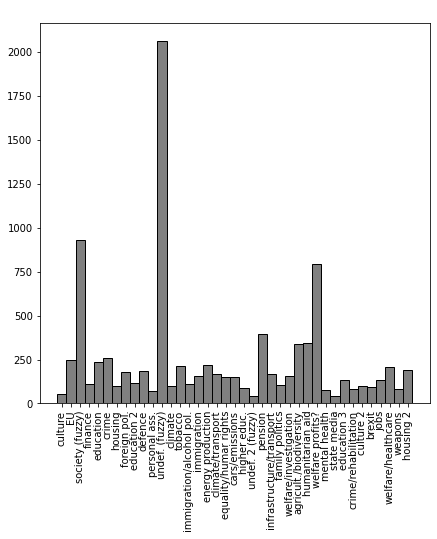

In [328]:
pred = kmeans39.predict(speech_vec)
#pred = kmeansCV.best_estimator_.predict(speech_vec)
plot_topic_distribution(pred, topic_dict)

### Printing some of the diffuse topics

In [331]:
topics = get_cluster_topics(kmeans39.cluster_centers_, inv_vocab, n=100, print_=False)
print(topics[11])
print(topics[2])

['år', 'se', 'vilja', 'skola', 'veta', 'ny', 'hel', 'böra', 'stå', 'sån', 'olik', 'frågestund', 'mången', 'mena', 'ålderspresident', 'avtal', 'viss', 'part', 'höja', 'polismyndighet', 'socialdemokratisk', 'skriva', 'dålig', 'engagemang', 'kontroll', 'kollektivavtal', 'proposition', 'notera', 'göteborg', 'förhandla', 'önska', 'konkret', 'kritik', 'arbetsgivare', 'bord', 'ram', 'varg', 'aktuell', 'initiativ', 'presentera', 'besked', 'tillkännagivande', 'gotland', 'process', 'näringsliv', 'arbetsplats', 'direktiv', 'produkt', 'relevant', 'tolka', 'investering', 'räkna', 'bero', 'verklighet', 'tanke', 'uttrycka', 'stoppa', 'bruka', 'allmänpolitisk', 'uttryck', 'konkurrenskraft', 'tagen', 'allmän', 'besluta', 'inlägg', 'klimate', 'nöja', 'omställning', 'uppfatta', 'otrolig', 'tag', 'leverera', 'slut', 'uppleva', 'bedömning', 'lön', 'säkerhet', 'handel', 'konflikt', 'råda', 'syn', 'jen', 'interpellationsdebatt', 'majoritet', 'sköta', 'rikta', 'förhandling', 'valrörelse', 'talarstol', 'dödsol

## Clustering of speeches of individual parties
Applying the model on speeches from individual parties, as well as clustering of individual party speeches.

In [279]:
speeches_S  = selected_speeches[selected_speeches.parti == 'S']
speeches_M  = selected_speeches[selected_speeches.parti == 'M']
speeches_MP = selected_speeches[selected_speeches.parti == 'MP']
speeches_SD = selected_speeches[selected_speeches.parti == 'SD']
speeches_C  = selected_speeches[selected_speeches.parti == 'C']
speeches_L  = selected_speeches[selected_speeches.parti == 'L']
speeches_V  = selected_speeches[selected_speeches.parti == 'V']
speeches_KD = selected_speeches[selected_speeches.parti == 'KD']

In [280]:
tokens_S = custom_preprocess(speeches_S, n_samples=1000)
tokens_M = custom_preprocess(speeches_M, n_samples=1000)

Time taken for 1000 speeches: 405.23 seconds
Time taken for 1000 speeches: 413.77 seconds


In [281]:
tokens_MP = custom_preprocess(speeches_MP, n_samples=1000)
tokens_SD = custom_preprocess(speeches_SD, n_samples=1000)

Number of samples was larger than data frame. Using maximum number of entries (809).
Time taken for 809 speeches: 311.20 seconds
Time taken for 1000 speeches: 458.60 seconds


In [282]:
tokens_C = custom_preprocess(speeches_C, n_samples=1000)
tokens_L = custom_preprocess(speeches_L, n_samples=1000)

Number of samples was larger than data frame. Using maximum number of entries (671).
Time taken for 671 speeches: 325.27 seconds
Number of samples was larger than data frame. Using maximum number of entries (560).
Time taken for 560 speeches: 264.43 seconds


In [283]:
tokens_V = custom_preprocess(speeches_V, n_samples=1000)
tokens_KD = custom_preprocess(speeches_KD, n_samples=1000)

Number of samples was larger than data frame. Using maximum number of entries (950).
Time taken for 950 speeches: 428.65 seconds
Number of samples was larger than data frame. Using maximum number of entries (821).
Time taken for 821 speeches: 367.01 seconds


In [332]:
speech_vec_S = vectorizer.transform(tokens_S)
speech_vec_M = vectorizer.transform(tokens_M)
speech_vec_MP = vectorizer.transform(tokens_MP)
speech_vec_SD = vectorizer.transform(tokens_SD)
speech_vec_C = vectorizer.transform(tokens_C)
speech_vec_L = vectorizer.transform(tokens_L)
speech_vec_V = vectorizer.transform(tokens_V)
speech_vec_KD = vectorizer.transform(tokens_KD)

In [333]:
pred_S = kmeans39.predict(speech_vec_S)
pred_M = kmeans39.predict(speech_vec_M)
pred_MP = kmeans39.predict(speech_vec_MP)
pred_SD = kmeans39.predict(speech_vec_SD)
pred_C = kmeans39.predict(speech_vec_C)
pred_L = kmeans39.predict(speech_vec_L)
pred_V = kmeans39.predict(speech_vec_V)
pred_KD = kmeans39.predict(speech_vec_KD)

Cluster with most data points: 11


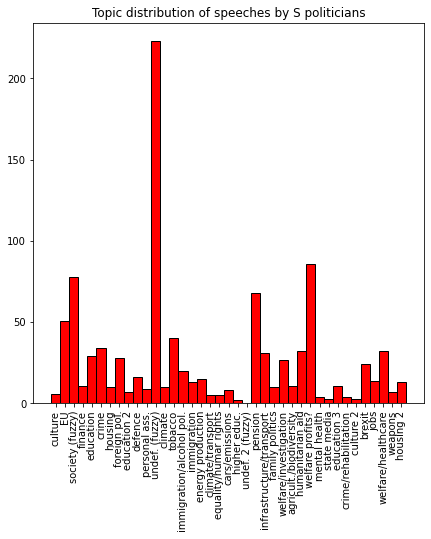

Cluster with most data points: 11


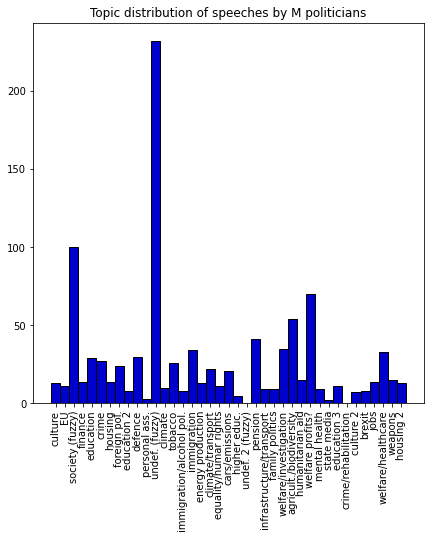

Cluster with most data points: 11


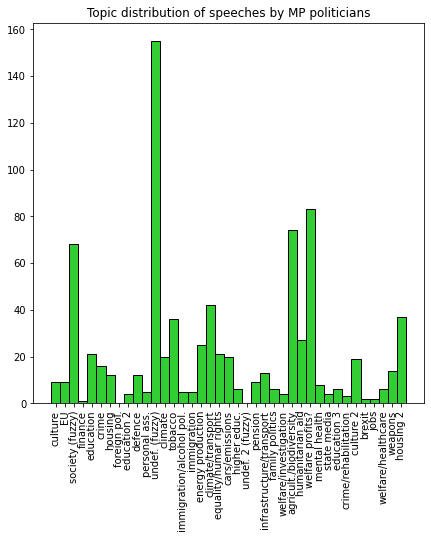

Cluster with most data points: 11


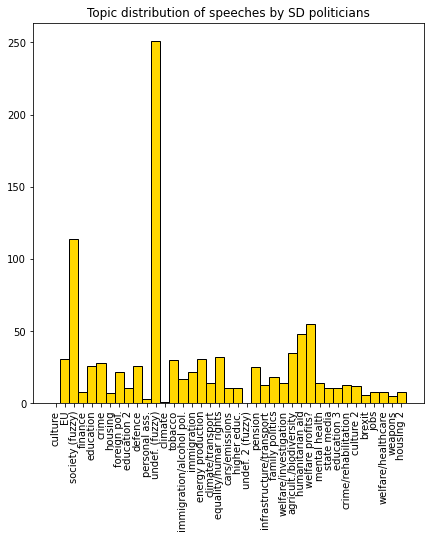

Cluster with most data points: 11


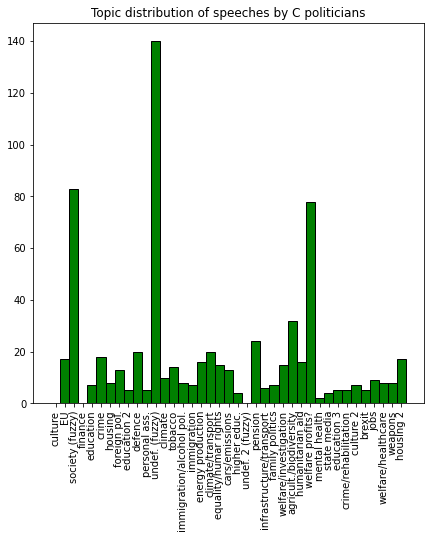

Cluster with most data points: 11


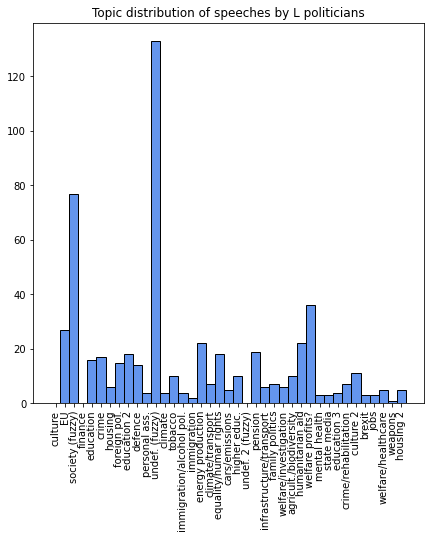

Cluster with most data points: 11


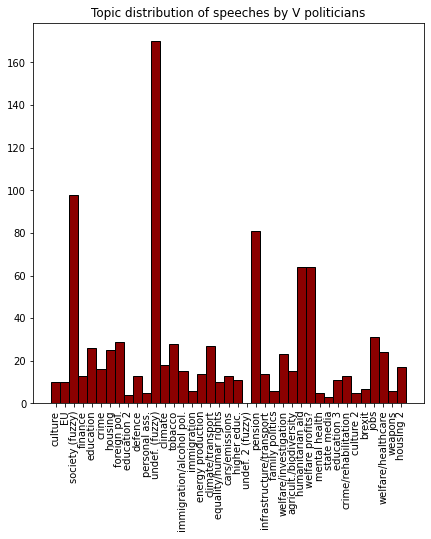

Cluster with most data points: 11


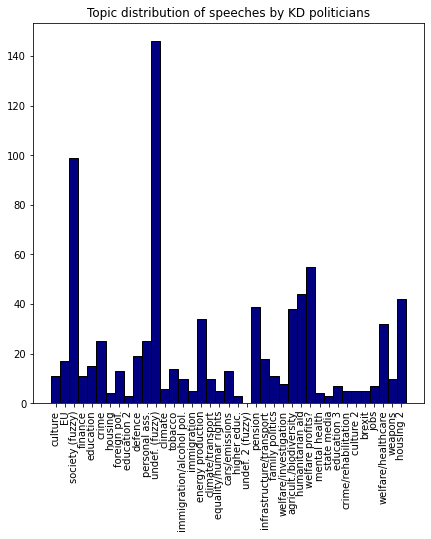

In [334]:
plot_topic_distribution(pred_S, topic_dict, 'S')
plot_topic_distribution(pred_M, topic_dict, 'M')
plot_topic_distribution(pred_MP, topic_dict, 'MP')
plot_topic_distribution(pred_SD, topic_dict, 'SD')
plot_topic_distribution(pred_C, topic_dict, 'C')
plot_topic_distribution(pred_L, topic_dict, 'L')
plot_topic_distribution(pred_V, topic_dict, 'V')
plot_topic_distribution(pred_KD, topic_dict, 'KD')

In [342]:
col = [f'c{i}' for i in range(nc)]
df_aggregated = pd.DataFrame(columns=col)

preds = [pred_S, pred_M, pred_MP, pred_SD, pred_KD, pred_V, pred_L, pred_C]

for i, party in enumerate(parties[0:-1]):
    counts, _ = np.histogram(preds[i], bins=[i-0.5 for i in range(nc+1)])
    cts = counts / np.sum(counts)
    df_aggregated = df_aggregated.append(dict(zip(col, list(cts))), ignore_index=True)
    
df_aggregated.index = parties[0:-1]
df_aggregated.columns = interpreted_topics
df_aggregated.style.background_gradient(axis=1)

,culture,EU,society (fuzzy),finance,education,crime,housing,foreign pol.,education 2,defence,personal ass.,undef. (fuzzy),climate,tobacco,immigration/alcohol pol.,immigration,energy production,climate/transport,equality/humar rights,cars/emissions,higher educ.,undef. 2 (fuzzy),pension,infrastructure/transport,family politics,welfare/investigation,agricult./biodiversity,humanitarian aid,welfare profits?,mental health,state media,education 3,crime/rehabilitation,culture 2,brexit,jobs,welfare/healthcare,weapons,housing 2
S,0.006000,0.051000,0.078000,0.011000,0.029000,0.034000,0.010000,0.028000,0.007000,0.016000,0.009000,0.223000,0.010000,0.040000,0.020000,0.013000,0.015000,0.005000,0.005000,0.008000,0.002000,0.000000,0.068000,0.031000,0.010000,0.027000,0.011000,0.032000,0.086000,0.004000,0.003000,0.011000,0.004000,0.003000,0.024000,0.014000,0.032000,0.007000,0.013000
M,0.013000,0.011000,0.100000,0.014000,0.029000,0.027000,0.014000,0.024000,0.008000,0.030000,0.003000,0.232000,0.010000,0.026000,0.008000,0.034000,0.013000,0.022000,0.011000,0.021000,0.005000,0.000000,0.041000,0.009000,0.009000,0.035000,0.054000,0.015000,0.070000,0.009000,0.002000,0.011000,0.000000,0.007000,0.008000,0.014000,0.033000,0.015000,0.013000
MP,0.011125,0.011125,0.084054,0.001236,0.025958,0.019778,0.014833,0.000000,0.004944,0.014833,0.006180,0.191595,0.024722,0.044499,0.006180,0.006180,0.030902,0.051916,0.025958,0.024722,0.007417,0.000000,0.011125,0.016069,0.007417,0.004944,0.091471,0.033375,0.102596,0.009889,0.004944,0.007417,0.003708,0.023486,0.002472,0.002472,0.007417,0.017305,0.045735
SD,0.000000,0.031000,0.114000,0.008000,0.026000,0.028000,0.007000,0.022000,0.011000,0.026000,0.003000,0.251000,0.001000,0.030000,0.017000,0.022000,0.031000,0.014000,0.032000,0.011000,0.011000,0.000000,0.025000,0.013000,0.018000,0.014000,0.035000,0.048000,0.055000,0.014000,0.011000,0.011000,0.013000,0.012000,0.006000,0.008000,0.008000,0.005000,0.008000
KD,0.013398,0.020706,0.120585,0.013398,0.018270,0.030451,0.004872,0.015834,0.003654,0.023143,0.030451,0.177832,0.007308,0.017052,0.012180,0.006090,0.041413,0.012180,0.006090,0.015834,0.003654,0.000000,0.047503,0.021924,0.013398,0.009744,0.046285,0.053593,0.066991,0.004872,0.003654,0.008526,0.006090,0.006090,0.006090,0.008526,0.038977,0.012180,0.051157
V,0.010526,0.010526,0.103158,0.013684,0.027368,0.016842,0.026316,0.030526,0.004211,0.013684,0.005263,0.178947,0.018947,0.029474,0.015789,0.006316,0.014737,0.028421,0.010526,0.013684,0.011579,0.000000,0.085263,0.014737,0.006316,0.024211,0.015789,0.067368,0.067368,0.005263,0.003158,0.011579,0.013684,0.005263,0.007368,0.032632,0.025263,0.006316,0.017895
L,0.000000,0.048214,0.137500,0.000000,0.028571,0.030357,0.010714,0.026786,0.032143,0.025000,0.007143,0.237500,0.007143,0.017857,0.007143,0.003571,0.039286,0.012500,0.032143,0.008929,0.017857,0.000000,0.033929,0.010714,0.012500,0.010714,0.017857,0.039286,0.064286,0.005357,0.005357,0.007143,0.012500,0.019643,0.005357,0.005357,0.008929,0.001786,0.008929
C,0.000000,0.025335,0.123696,0.000000,0.010432,0.026826,0.011923,0.019374,0.007452,0.029806,0.007452,0.208644,0.014903,0.020864,0.011923,0.010432,0.023845,0.029806,0.022355,0.019374,0.005961,0.000000,0.035768,0.008942,0.010432,0.022355,0.047690,0.023845,0.116244,0.002981,0.005961,0.007452,0.007452,0.010432,0.007452,0.013413,0.011923,0.011923,0.025335


In [349]:
df_aggregated.iloc[:,3:11].style.background_gradient(axis=1)

,finance,education,crime,housing,foreign pol.,education 2,defence,personal ass.
S,0.011000,0.029000,0.034000,0.010000,0.028000,0.007000,0.016000,0.009000
M,0.014000,0.029000,0.027000,0.014000,0.024000,0.008000,0.030000,0.003000
MP,0.001236,0.025958,0.019778,0.014833,0.000000,0.004944,0.014833,0.006180
SD,0.008000,0.026000,0.028000,0.007000,0.022000,0.011000,0.026000,0.003000
KD,0.013398,0.018270,0.030451,0.004872,0.015834,0.003654,0.023143,0.030451
V,0.013684,0.027368,0.016842,0.026316,0.030526,0.004211,0.013684,0.005263
L,0.000000,0.028571,0.030357,0.010714,0.026786,0.032143,0.025000,0.007143
C,0.000000,0.010432,0.026826,0.011923,0.019374,0.007452,0.029806,0.007452


In [350]:
df_aggregated.iloc[:,12:20].style.background_gradient(axis=1)

,climate,tobacco,immigration/alcohol pol.,immigration,energy production,climate/transport,equality/humar rights,cars/emissions
S,0.010000,0.040000,0.020000,0.013000,0.015000,0.005000,0.005000,0.008000
M,0.010000,0.026000,0.008000,0.034000,0.013000,0.022000,0.011000,0.021000
MP,0.024722,0.044499,0.006180,0.006180,0.030902,0.051916,0.025958,0.024722
SD,0.001000,0.030000,0.017000,0.022000,0.031000,0.014000,0.032000,0.011000
KD,0.007308,0.017052,0.012180,0.006090,0.041413,0.012180,0.006090,0.015834
V,0.018947,0.029474,0.015789,0.006316,0.014737,0.028421,0.010526,0.013684
L,0.007143,0.017857,0.007143,0.003571,0.039286,0.012500,0.032143,0.008929
C,0.014903,0.020864,0.011923,0.010432,0.023845,0.029806,0.022355,0.019374


In [356]:
df_aggregated.iloc[:,20:28].style.background_gradient(axis=1)

,higher educ.,undef. 2 (fuzzy),pension,infrastructure/transport,family politics,welfare/investigation,agricult./biodiversity,humanitarian aid
S,0.002000,0.000000,0.068000,0.031000,0.010000,0.027000,0.011000,0.032000
M,0.005000,0.000000,0.041000,0.009000,0.009000,0.035000,0.054000,0.015000
MP,0.007417,0.000000,0.011125,0.016069,0.007417,0.004944,0.091471,0.033375
SD,0.011000,0.000000,0.025000,0.013000,0.018000,0.014000,0.035000,0.048000
KD,0.003654,0.000000,0.047503,0.021924,0.013398,0.009744,0.046285,0.053593
V,0.011579,0.000000,0.085263,0.014737,0.006316,0.024211,0.015789,0.067368
L,0.017857,0.000000,0.033929,0.010714,0.012500,0.010714,0.017857,0.039286
C,0.005961,0.000000,0.035768,0.008942,0.010432,0.022355,0.047690,0.023845


In [354]:
df_aggregated.iloc[:,29:39].style.background_gradient(axis=1)

,mental health,state media,education 3,crime/rehabilitation,culture 2,brexit,jobs,welfare/healthcare,weapons,housing 2
S,0.004000,0.003000,0.011000,0.004000,0.003000,0.024000,0.014000,0.032000,0.007000,0.013000
M,0.009000,0.002000,0.011000,0.000000,0.007000,0.008000,0.014000,0.033000,0.015000,0.013000
MP,0.009889,0.004944,0.007417,0.003708,0.023486,0.002472,0.002472,0.007417,0.017305,0.045735
SD,0.014000,0.011000,0.011000,0.013000,0.012000,0.006000,0.008000,0.008000,0.005000,0.008000
KD,0.004872,0.003654,0.008526,0.006090,0.006090,0.006090,0.008526,0.038977,0.012180,0.051157
V,0.005263,0.003158,0.011579,0.013684,0.005263,0.007368,0.032632,0.025263,0.006316,0.017895
L,0.005357,0.005357,0.007143,0.012500,0.019643,0.005357,0.005357,0.008929,0.001786,0.008929
C,0.002981,0.005961,0.007452,0.007452,0.010432,0.007452,0.013413,0.011923,0.011923,0.025335


## Short analysis
K-means is a very simple clustering method, and might yield non-satisfactory results due to the fact that there is no true division of topics.

The generic topics dominate even when using a lemmatizer. Perhaps the feature space is too large? Looking at the 300 most common words reveals that they carry relatively little information on the topic. Will the results be improved by throwing away the most common words? Can we throw away some of the least common words?

__Another approach might be to remove the speeches that are of no specific category or bring up many topics (e.g. 'frågestund', 'partiledardebatt') and evaluate on the given subject labels (see data inspection).__

__It may be hard to classify unseen speeches since if the 'content words' have not been seen the speech will contain mostly generic words (like 'sverige' or 'regeringen') and the speech will be closest to the 'scrap' class.__ (Try to work only with seen documents.)

One can also try using KBs Swedish spacy POS tagger combined with lemmatizer `lemmy`

### Clustering of current debate

In [95]:
n_docs_ad = 2000
tokens_arendedebatt = custom_preprocess(arendedebatt, n_docs_ad, random=True)

Time taken for 2000 speeches: 1464.3 seconds


In [96]:
speech_vec_ad = vectorizer.transform(tokens_arendedebatt)

nc = 39
kmeans39_ad = KMeans(n_clusters = nc, n_init=10)
kmeans39_ad.fit(speech_vec_ad)

KMeans(n_clusters=39)

In [97]:
topics_ad = get_cluster_topics(kmeans39_ad.cluster_centers_, n=20, print_=True)

['kuba', 'avtal', 'kubansk', 'moderat', 'ålderspresident', 'usa', 'kubas', 'dialog', 'eu', 'strejkrätt', 'diktatur', 'regim', 'rättighet', 'mänsklig', 'union', 'europeiska', 'kommunistdiktatur', 'sida', 'fri', 'alliera']
['barn', 'ung', 'psykisk', 'ohälsa', 'moderat', 'förskola', 'ungdom', 'samhälle', 'kriminell', 'många', 'förskoleklass', 'förebygga', 'vuxen', 'brottsoff', 'socialtjänst', 'ålder', 'vård', 'idrott', 'väldig', 'tid']
['skatt', 'kristdemokrat', 'punktskatt', 'skatteväxling', 'sänka', 'miljöskatt', 'grön', 'skattesänkning', 'minska', 'sverige', 'människa', 'utsläpp', 'skattesystem', 'socialdemokrat', 'tycka', 'företag', 'leda', 'regering', 'införa', 'öka']
['centerparti', 'parti', 'regering', 'borgerlig', 'sverige', 'vänsterparti', 'tycka', 'socialdemokrat', 'liberal', 'sverigedemokrat', 'skatt', 'moderat', 'punktskatt', 'tydlig', 'förslag', 'moms', 'höra', 'cigarett', 'antirasist', 'ändra']
['elev', 'lärare', 'betyg', 'prov', 'barn', 'undervisning', 'grundskola', 'utbild

Cluster with most data points: 18


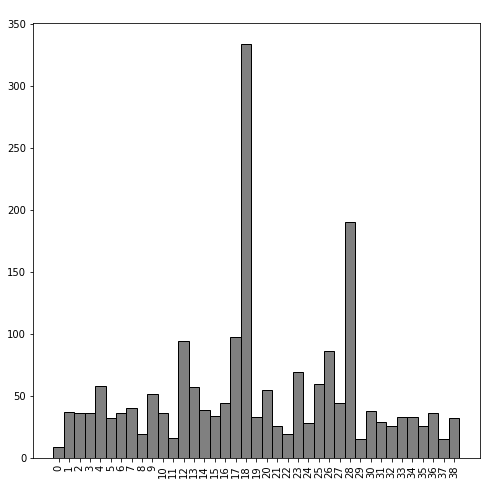

In [98]:
topic_dict = dict(zip(range(nc), range(nc)))
pred_ad = kmeans39_ad.predict(speech_vec_ad)
plot_topic_distribution(pred_ad, topic_dict)

In [100]:
print(topics_ad[18])

['tycka', 'sverige', 'regering', 'förslag', 'handla', 'väldig', 'person', 'land', 'lagstiftning', 'parti', 'riksdag', 'moderat', 'sak', 'utredning', 'många', 'exempel', 'tid', 'just', 'fatta', 'fungera']


## Dimensionality reduction: Removing the least common words and reclustering (not updated)

In [230]:
vectorizer_filtered = TfidfVectorizer(stop_words=sw_large) # tokenizer=preprocess)
speech_vec_filtered = vectorizer_filtered.fit_transform(tokens)
vocab_filtered = vectorizer_filtered.vocabulary_
inv_vocab_filtered = {val:key for key, val in vocab_filtered.items()}

c:\users\joel_\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['britt', 'caren', 'el', 'kultur', 'petersen'] not in stop_words.
  warnings.warn(


In [231]:
# Much fewer dimensions
print(speech_vec.shape)
print(speech_vec_uncommon.shape)
print(speech_vec_filtered.shape)

(9387, 46659)
(10000, 52767)
(9387, 2349)


In [247]:
nc = 13
kmeans39_filtered = KMeans(n_clusters = nc, n_init=10, random_state=100)
kmeans39_filtered.fit(speech_vec_filtered)

KMeans(n_clusters=13, random_state=100)

Cluster with most data points: 1


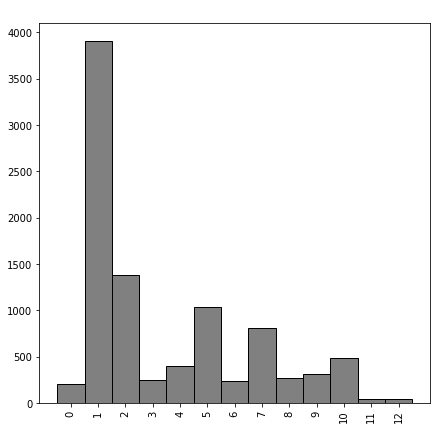

In [248]:
topic_dict = dict(zip(range(nc), range(nc)))
pred_filtered = kmeans39_filtered.predict(speech_vec_filtered)
plot_topic_distribution(pred_filtered, topic_dict)

In [249]:
top = get_cluster_topics(kmeans39_filtered.cluster_centers_, inv_vocab_filtered, n=100, print_=True)

['psykisk', 'försäkringskassa', 'ohälsa', 'sjukförsäkring', 'sjukersättning', 'generaldirektör', 'sjuk', 'sjukskrivning', 'vilja', 'se', 'sjukdom', 'år', 'bedömning', 'skola', 'sjukskriven', 'riksrevision', 'läkare', 'arbetsförmedling', 'mången', 'rehabilitering', 'arbetsliv', 'hel', 'olik', 'böra', 'diagnos', 'förebygga', 'regelverket', 'arbetsplats', 'dålig', 'må', 'björnsdott', 'mena', 'arbetsgivare', 'stress', 'försäkring', 'veta', 'handling', 'stå', 'departement', 'stol', 'kritik', 'ku', 'ersättning', 'neka', 'ny', 'individ', 'skriva', 'avslag', 'sån', 'lida', 'aktör', 'uppleva', 'folkhälsa', 'arbetsmiljö', 'frisk', 'förtroende', 'ungdom', 'vända', 'dåvarande', 'primärvård', 'bevilja', 'rättssäker', 'socialdemokratisk', 'behandla', 'samverkan', 'fysisk', 'konstitutionsutskott', 'direktiv', 'bedöma', 'vanlig', 'patient', 'strategi', 'feministisk', 'kontakt', 'behandling', 'trygg', 'orsak', 'hantering', 'synpunkt', 'landsting', 'tjänsteman', 'ålder', 'kd', 'frågestund', 'översyn', '

In [237]:
print(top[1], "\n")
print(top[2], "\n")
print(top[9], "\n")
print(top[12], "\n")
print(top[31], "\n")

['se', 'olik', 'vilja', 'hel', 'veta', 'skola', 'ny', 'nordisk', 'år', 'stå', 'lss', 'sån', 'böra', 'sondmatning', 'viss', 'assista', 'interpellationsdebatt', 'andning', 'mången', 'personlig', 'mena', 'kompet', 'dialog', 'process', 'konkret', 'frågestund', 'funktionsnedsättning', 'dålig', 'socialtjänst', 'generell', 'förstås', 'riktning', 'verktyg', 'trygg', 'aktör', 'individ', 'bedömning', 'helhet', 'uppleva', 'perspektiv', 'avtal', 'verklighet', 'skriva', 'prioritering', 'syn', 'bransch', 'lokal', 'proposition', 'engagemang', 'socialminister', 'grann', 'betydlig', 'otrolig', 'angelägen', 'oro', 'påbörja', 'utgå', 'näring', 'ambition', 'exakt', 'utreda', 'grön', 'räkna', 'höja', 'samsyn', 'arbetsgivare', 'näringsliv', 'liknande', 'norden', 'kammare', 'strategi', 'önska', 'igång', 'fundera', 'intention', 'räcka', 'replik', 'initiativ', 'våld', 'övergångsregering', 'personal', 'relevant', 'vända', 'sektor', 'landa', 'uppskatta', 'direktiv', 'underlag', 'tanke', 'sommar', 'vänta', 'lever

2349


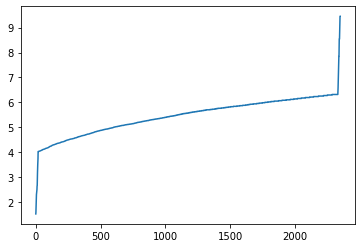

In [236]:
idfs = np.sort(vectorizer_filtered.idf_)
print(len(idfs))
plt.plot(idfs)
plt.show()